In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import cv2
import os
import numpy as np

def hair_removal(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise and preserve edges
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Morphological Gradient to emphasize edges
    kernel = np.ones((5, 5), np.uint8)
    gradient = cv2.morphologyEx(blurred, cv2.MORPH_GRADIENT, kernel)

    # Thresholding to obtain a binary image
    _, thresh = cv2.threshold(gradient, 20, 255, cv2.THRESH_BINARY)

    # Inpainting to remove detected areas (hair)
    hair_removed = cv2.inpaint(image, thresh, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    return hair_removed

def preprocess_and_save_images(input_directory, output_directory):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # List all files in the input directory
    files = os.listdir(input_directory)
    
    # Ensure output directory is empty before processing
    existing_files = os.listdir(output_directory)
    if len(existing_files) > 0:
        print("Output directory is not empty. Clearing contents...")
        for file in existing_files:
            os.remove(os.path.join(output_directory, file))
    
    for file_name in files:
        # Check if the file is an image (you can add more image file extensions if needed)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            # Load the image using OpenCV
            image_path = os.path.join(input_directory, file_name)
            image = cv2.imread(image_path)  # Assuming images are in BGR format
            
            # Remove hair from the image
            hair_removed_image = hair_removal(image)
            
            # Convert BGR to RGB
            hair_removed_image = cv2.cvtColor(hair_removed_image, cv2.COLOR_BGR2RGB)
            
            # Normalize the image values (assuming the image contains values between 0 and 255)
            processed_image = hair_removed_image / 255.0
            
            # Convert to float32
            processed_image = processed_image.astype('float32')
            
            # Save the processed image to the output directory
            output_path = os.path.join(output_directory, file_name)
            cv2.imwrite(output_path, (processed_image * 255).astype('uint8'))
        else:
            print(f"Skipping file {file_name}. Not an image file.")
    print("Preprocessing complete.")

# Input directory containing the original images
input_image_directory = '/kaggle/input/skin-cancer-lesions-segmentation/data/images/'

# Output directory to save processed images
output_image_directory = '/kaggle/working/modify_images/'

# Preprocess images (including hair removal) from input directory and save them to the output directory
preprocess_and_save_images(input_image_directory, output_image_directory)


In [ ]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    dice = (2. * intersection + smooth) / (union + smooth)
    loss = 1. - K.mean(dice)
    return loss

# Define the dice coefficient function
def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")
 


# Assuming you have input_data and output_masks for 10,000 images
# Train the model with callbacks


In [4]:
# import glob
import os
from glob import glob
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.layers as K
from tqdm import tqdm
import cv2
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
smooth = 1e-15


In [2]:
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    iou_score = (intersection + 100) / (sum_ - intersection + 100)
    return iou_score
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)



In [5]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
# """ Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape
    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)
    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1=Conv2D(filters=128, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y_1)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)
    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same',use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)
    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same',use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)
    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)
    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])
    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y


In [6]:
def DeepLabV3Plus(shape):
    inputs = Input(shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)
#  """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)
    x = Concatenate()([x_a, x_b])
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
#  """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)
#  """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

In [7]:
H = 256
W = 256
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=split_size, random_state=42)
    return (train_x, train_y), (test_x, test_y), (valid_x, valid_y)
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x=x/255.
    x = x.astype(np.float32)
    return x
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE) ## (h, w)
    x = cv2.resize(x, (W, H)) ## (h, w) ## (h, w)
    x=x/255.
    x = x.astype(np.float32) ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x


In [8]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [10]:
if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)
create_dir("files")
batch_size = 8
lr = 1e-4
num_epochs = 15
model_path = os.path.join("files", "model.h5")


In [11]:
csv_path = os.path.join("files", "log.csv")
dataset_path = "/kaggle/input/skin-cancer-lesions-segmentation/data"
(train_x, train_y), (test_x, test_y) , (valid_x,valid_y)= load_dataset(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)
callbacks = [ 
 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
 CSVLogger(csv_path),
 EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
 ]
model =DeepLabV3Plus((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

Train: 8012 - 8012
Valid: 2003 - 2003
Test : 2003 - 2003
94765736/94765736 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [10]:
model.fit(
 train_dataset,
 epochs=num_epochs,
 validation_data=valid_dataset,
callbacks=callbacks
 )

Epoch 1/15
1002/1002 [==============================] - 329s 282ms/step - loss: 0.0933 - dice_coef: 0.9067 - val_loss: 0.1041 - val_dice_coef: 0.8956 - lr: 1.0000e-04
Epoch 2/15
1002/1002 [==============================] - 272s 271ms/step - loss: 0.0602 - dice_coef: 0.9399 - val_loss: 0.0699 - val_dice_coef: 0.9297 - lr: 1.0000e-04
Epoch 3/15
1002/1002 [==============================] - 271s 270ms/step - loss: 0.0493 - dice_coef: 0.9507 - val_loss: 0.0618 - val_dice_coef: 0.9379 - lr: 1.0000e-04
Epoch 4/15
1002/1002 [==============================] - 271s 271ms/step - loss: 0.0435 - dice_coef: 0.9565 - val_loss: 0.0712 - val_dice_coef: 0.9284 - lr: 1.0000e-04
Epoch 5/15
1002/1002 [==============================] - 271s 270ms/step - loss: 0.0401 - dice_coef: 0.9599 - val_loss: 0.0668 - val_dice_coef: 0.9328 - lr: 1.0000e-04
Epoch 6/15
1002/1002 [==============================] - 270s 269ms/step - loss: 0.0384 - dice_coef: 0.9616 - val_loss: 0.0628 - val_dice_coef: 0.9368 - lr: 1.0000e-0

In [12]:
model.evaluate(test_dataset)

251/251 [==============================] - 27s 105ms/step - loss: 0.0593 - dice_coef: 0.9402


[0.05930094048380852, 0.9402182698249817]

In [11]:
model.save('model_deplab.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
IoU Score: 0.9387, Dice Score: 0.9684
1/1 [==============================] - 0s 38ms/step
IoU Score: 0.8121, Dice Score: 0.8963
1/1 [==============================] - 0s 33ms/step
IoU Score: 0.9070, Dice Score: 0.9512
1/1 [==============================] - 0s 26ms/step
IoU Score: 0.9201, Dice Score: 0.9584
1/1 [==============================] - 0s 32ms/step
IoU Score: 0.9318, Dice Score: 0.9647
1/1 [==============================] - 0s 29ms/step
IoU Score: 0.8655, Dice Score: 0.9279
1/1 [==============================] - 0s 34ms/step
IoU Score: 0.9332, Dice Score: 0.9655
1/1 [==============================] - 0s 30ms/step
IoU Score: 0.8342, Dice Score: 0.9096
1/1 [==============================] - 0s 28ms/step
IoU Score: 0.7035, Dice Score: 0.8260
1/1 [==============================] - 0s 32ms/step
IoU Score: 0.8191, Dice Score: 0.9006
1/1 [==============================] - 0s 34ms/step
IoU Score: 0.8392, Dice Score: 0.9126
1/1 [=====

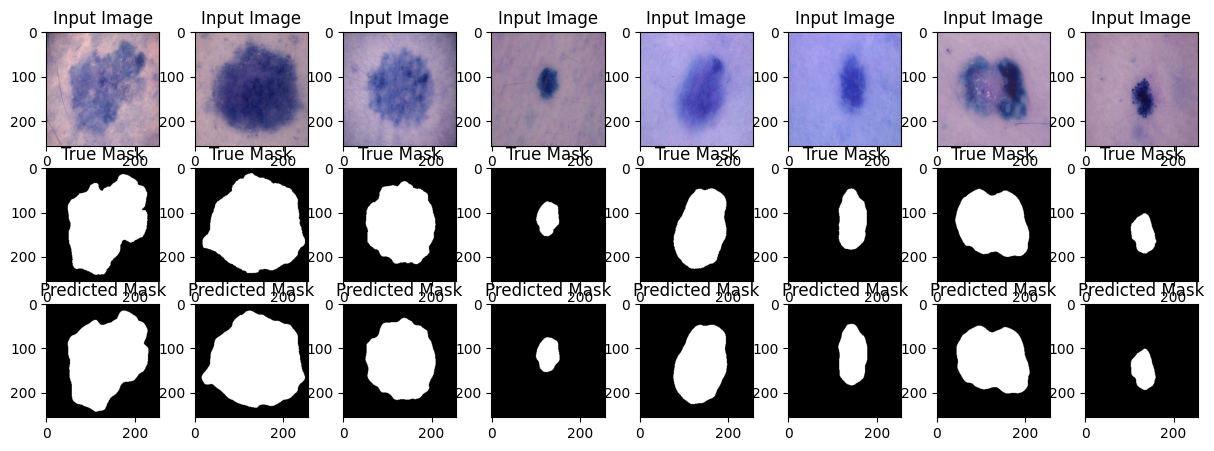

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def calculate_iou_score(true_mask, predicted_mask):
    intersection = np.logical_and(true_mask, predicted_mask)
    union = np.logical_or(true_mask, predicted_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice_score(true_mask, predicted_mask):
    intersection = np.logical_and(true_mask, predicted_mask)
    dice_score = 2 * np.sum(intersection) / (np.sum(true_mask) + np.sum(predicted_mask))
    return dice_score

# Assuming model_dep is your trained model and valid_dataset is your testing dataset
# Make sure your model is compatible with TensorFlow

max_iou_score = 0
max_dice_score = 0
best_images = None
best_true_masks = None
best_predicted_masks = None

# Loop through your test dataset
for input_images, true_masks in valid_dataset:
    predicted_masks = model_deep.predict(input_images)  # Replace with actual prediction logic

    # Assuming true_masks and predicted_masks are binary masks
    true_masks = true_masks > 0.5
    predicted_masks = predicted_masks > 0.5

    iou_score = calculate_iou_score(true_masks, predicted_masks)
    dice_score = calculate_dice_score(true_masks, predicted_masks)

    print(f"IoU Score: {iou_score:.4f}, Dice Score: {dice_score:.4f}")

    # Update the best images if the current one has a higher IoU and Dice score
    if iou_score > max_iou_score and dice_score > max_dice_score:
        max_iou_score = iou_score
        max_dice_score = dice_score
        best_images = input_images
        best_true_masks = true_masks
        best_predicted_masks = predicted_masks

# Print the best IoU and Dice Scores
print("Best IoU and Dice Scores:")
print(f"IoU Score: {max_iou_score:.4f}, Dice Score: {max_dice_score:.4f}")

# Display or save the best images, true masks, and predicted masks as needed
# Use your own visualization or saving logic based on your application.
# For example, you can use libraries like matplotlib for visualization.

# Visualize the best images
num_images = best_images.shape[0]

plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(best_images[i].numpy())
    plt.title("Input Image")

    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(best_true_masks[i], cmap='gray')
    plt.title("True Mask")

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow(best_predicted_masks[i], cmap='gray')
    plt.title("Predicted Mask")

plt.show()
